In [119]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
DEBUG = False
class Ball:
    def __init__(self, team, label, loc):
        self.team = team
        self.label = label
        self.loc = loc

In [120]:
def mask_table(color_img):
    pixels = []
    for i in color_img:
        for j in i:
            pixels.append(j)
    pixels = np.array(pixels)
    bins = [0,100,150,255]
    hist, bins = np.histogramdd(pixels, bins=(bins, bins, bins))

    # find the highest histogram bin
    max_r, max_g, max_b, max_val = 0, 0, 0, 0
    for r in range(hist.shape[0]):
        for g in range(hist.shape[1]):
            for b in range(hist.shape[2]):
                if hist[r][g][b] > max_val:
                    max_val = hist[r][g][b]
                    (max_r, max_g, max_b) = r, g, b
    bins = bins[0]
    lower = np.array([bins[max_r], bins[max_g], bins[max_b]])
    upper = np.array([bins[max_r + 1], bins[max_g + 1], bins[max_b + 1]])
    # just get the pixels in the highest histogram bin
    mask = cv2.inRange(color_img, lower, upper)
    # fill in the holes
    kernel = np.ones((7, 7),np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=10)
    # dilation is grayscale, lets convert it to have three channels
    rgb_dilation = np.uint8(np.zeros((dilation.shape[0], dilation.shape[1], 3)))
    for i in range(rgb_dilation.shape[0]):
        for j in range(rgb_dilation.shape[1]):
            rgb_dilation[i][j][:] = dilation[i][j]

    res = cv2.bitwise_and(color_img, rgb_dilation)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    if DEBUG:
        plt.imshow(res)
        plt.show()
    return dilation, res

In [121]:
def hough_circles(masked_image, output_file):
    cimg = masked_image.copy()
    gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    h_circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT_ALT,param1=100, param2=0.7, dp=1.5, minRadius=12, maxRadius=15, minDist=11)
    if h_circles is None:
        return []
    h_circles = np.uint16(np.around(h_circles))

    k = 0
    for i in h_circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
        k+=1

    if DEBUG:
        plt.title("Hough Circles")
        plt.imshow(cimg)
    # cv2.imwrite(output_file, cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
    return h_circles

In [122]:
def label_balls(color_img, hough_circs, output_file):
    ## get the pixel values of all the circles
    balls = []
    num_solids = 0
    num_stripes = 0
    if len(hough_circs) == 0:
        return balls
    for circle in hough_circs[0,:]:
        rad = circle[2]
        center_x = circle[1]
        center_y = circle[0]
        # iterate over the box containing the circle
        num_colored = 0
        num_white = 0
        num_black = 0
        for i in range(2*rad):
            for j in range(2*rad):
                tmp_x = center_x - rad + i
                tmp_y = center_y - rad + j
                # check that the point is actually in the circle
                if (tmp_x - center_x)**2 + (tmp_y - center_y)**2 < rad**2:
                    pix = color[tmp_x][tmp_y]
                    white_thresh = 100
                    black_thresh = 50
                    # the white pixels
                    if pix[0] > white_thresh and pix[1] > white_thresh and pix[2] > white_thresh:
                        num_white += 1
                    # the black pixels
                    elif pix[0] < black_thresh and pix[1] < black_thresh and pix[2] < black_thresh:
                        num_black += 1
                    else:
                        num_colored += 1
        total_pixels = num_white + num_black + num_colored
        # print(num_white / total_pixels)
        if num_white / total_pixels >= 0.95:
            ball = Ball(team=None, label="cue", loc=(center_y, center_x))
        elif num_black / total_pixels >= 0.8:
            ball = Ball(team=None, label="eight", loc=(center_y, center_x))
        elif num_white / total_pixels >= 0.25:
            ball = Ball(team="stripes", label=str(num_stripes), loc=(center_y, center_x))
            num_stripes += 1
        else:
            ball = Ball(team="solids", label=str(num_solids), loc=(center_y, center_x))
            num_solids += 1
        balls.append(ball)

    labeled_balls = color_img.copy()
    for b in balls:
        if b.team == 'solids': col = (0,255,0)
        if b.team == 'stripes': col = (255,0,255)
        if b.team == None: col = (255,150,0)
        cv2.putText(labeled_balls, b.team if b.team else b.label, (b.loc[0],b.loc[1]), cv2.FONT_HERSHEY_PLAIN, 1, col, 1)
        cv2.circle(labeled_balls,(b.loc[0],b.loc[1]),2,col,2)

    if DEBUG:
        plt.imshow(cv2.cvtColor(labeled_balls, cv2.COLOR_BGR2RGB))
    cv2.imwrite(output_file, labeled_balls)
    return balls

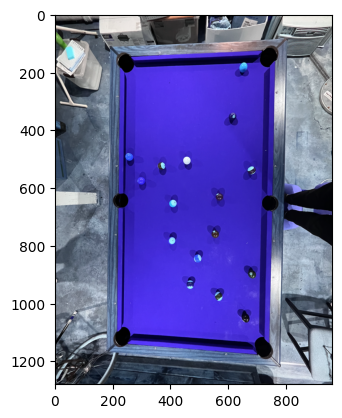

In [123]:
  
x1='images/all_balls/1280x1280/IMG_2735.png'
grayscale = cv2.imread(x1, 0)
image1 = cv2.imread(x1,1)

plt.imshow(image1)
plt.show() 
  

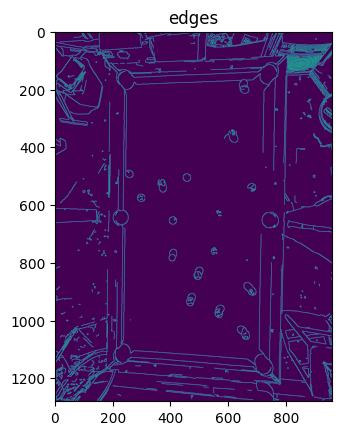

In [124]:
img_blur = cv2.GaussianBlur(grayscale, (3,3), 0) 
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
plt.title('edges')
plt.imshow(edges)
plt.show()

Limit the image to only the pool table. Credit to Ben.
Perhaps could optimize to use a histogram to progamatically get the color of the felt

In [125]:
# # order is blue, green, red
# lower_blue = np.array([0,0,150])
# upper_blue = np.array([150,100,255])
# # Threshold the HSV image to get only blue colors
# mask = cv2.inRange(image1, lower_blue, upper_blue)
# erosion = mask
# kernel = np.ones((7,7),np.uint8)
# dilation = cv2.dilate(erosion, kernel, iterations = 4)
mask, result = mask_table(image1)

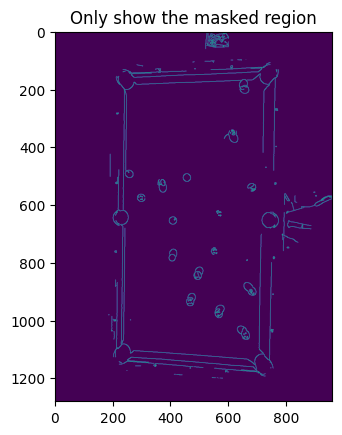

In [126]:
res = cv2.bitwise_and(edges, mask)
plt.title('Only show the masked region')
plt.imshow(res)
plt.show()

722.8898835997768 12.618089756421552
(696, 1512) (749, -1487)
6.735602284241807 192.8824296349165
(-1492, 245) (1505, 140)
246.96238070421145 4.310744356619811
(220, 1504) (273, -1495)
-95.69703427336117 1093.821775990624
(-1589, 963) (1398, 1224)
253.9613145703227 4.432911200734543
(227, 1504) (280, -1495)
762.8837914061269 13.316186008505731
(736, 1513) (789, -1486)
8.478427718253645 161.77798448313771
(-1489, 240) (1506, 83)
759.8842483206506 13.263828789599419
(733, 1513) (786, -1486)


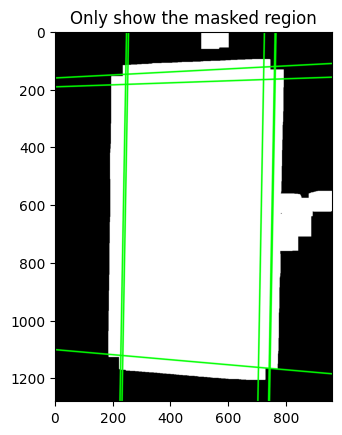

In [127]:

import math

msk_lines = np.zeros((1280, 1280,3), dtype=np.uint8)
img_lines = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(res,1,np.pi/180,190,None,0,0)
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            print(x0, y0)
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            print (pt1, pt2)
            cv2.line(msk_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)
            cv2.line(img_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)

plt.title('Only show the masked region')
plt.imshow(img_lines)
plt.show()

https://www.geeksforgeeks.org/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/?ref=rp
Shi-Thomas Corner Detection

(254, 180)
(237, 1126)
(716, 171)
(699, 1159)


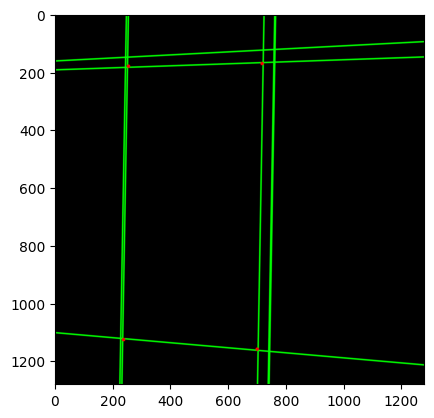

In [128]:
gry_msk_lines = cv2.cvtColor(msk_lines, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gry_msk_lines, 100, 0.01, 10)
msk_lines_out = msk_lines.copy()

corners = np.intp(corners)
h,w, = msk_lines_out.shape[:2]
c1 = [0, 0]
c2 = [0, w]
c3 = [h, 0]
c4 = [h, w]

center = [h/2, w/2]

table_c_dist1 = math.dist(c1, center)
table_c_dist2 = math.dist(c2, center)
table_c_dist3 = math.dist(c3, center)
table_c_dist4 = math.dist(c4, center)

table_cornerUL = c1
table_cornerLL = c2
table_cornerUR = c3
table_cornerLR = c4

for i in corners:
    x, y = i.ravel()
    euc_1 = math.dist(c1,[x,y])
    euc_2 = math.dist(c2,[x,y])
    euc_3 = math.dist(c3,[x,y])
    euc_4 = math.dist(c4,[x,y])

    dist = [euc_1, euc_2, euc_3, euc_4]
    min_euc = min(dist)

    if euc_1 == min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist1:
            table_c_dist1 = euc_cen
            table_cornerUL = (x,y)
    elif euc_2 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist2:
            table_c_dist2 = euc_cen
            table_cornerLL = (x,y)    
    elif euc_3 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist3:
            table_c_dist3 = euc_cen
            table_cornerUR = (x,y) 
    else:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist4:
            table_c_dist4 = euc_cen
            table_cornerLR = (x,y) 
    # find which quadrant
    # draw red color circles on all corners
print(table_cornerUL)
print(table_cornerLL)
print(table_cornerUR)
print(table_cornerLR)

cv2.circle(msk_lines_out, table_cornerUL, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerLL, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerUR, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerLR, 6, (255, 0, 0), -1)

# resulting image
plt.imshow(msk_lines_out)


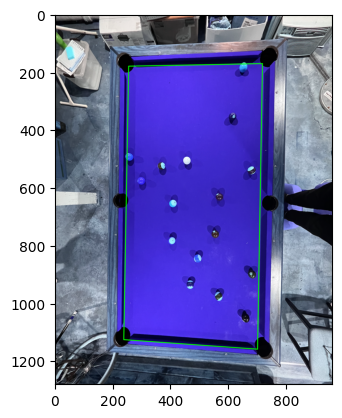

In [129]:
img_draw_box = image1.copy()


cv2.line(img_draw_box, table_cornerUL, table_cornerUR, (0,255,0), 2, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerUR, table_cornerLR, (0,255,0), 2, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerLR, table_cornerLL, (0,255,0), 2, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerLL, table_cornerUL, (0,255,0), 2, cv2.LINE_AA)

plt.imshow(img_draw_box)

https://theailearner.com/tag/cv2-getperspectivetransform/

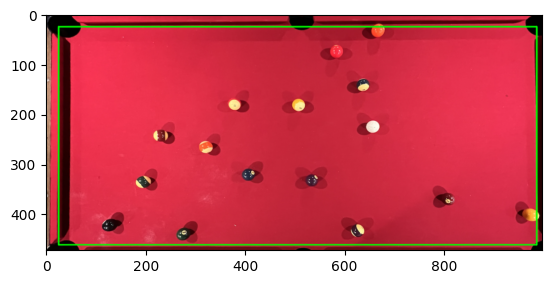

In [130]:
src_cor = np.float32([table_cornerLL, table_cornerLR, table_cornerUR, table_cornerUL])
width_1 = math.dist(table_cornerLL, table_cornerUL)
width_2 = math.dist(table_cornerLR, table_cornerUR)
max_width = max(int(width_1), int(width_2))

height_1 = math.dist(table_cornerLL, table_cornerLR)
height_2 = math.dist(table_cornerUL, table_cornerUR)
max_height = max(int(height_1), int(height_2))
dst_corLL = [25, 25]
dst_corLR = [25, max_height - 1]
dst_corUR = [max_width - 1, max_height - 1]
dst_corUL = [max_width - 1, 25]
dst_cor = np.float32([dst_corLL, dst_corLR, dst_corUR, dst_corUL])

M = cv2.getPerspectiveTransform(src_cor, dst_cor)
rotated_table = cv2.warpPerspective(img_draw_box,M,(max_width+10, max_height+10),flags=cv2.INTER_LINEAR)
final_out = cv2.cvtColor(rotated_table, cv2.COLOR_BGR2RGB)


plt.imshow(final_out)

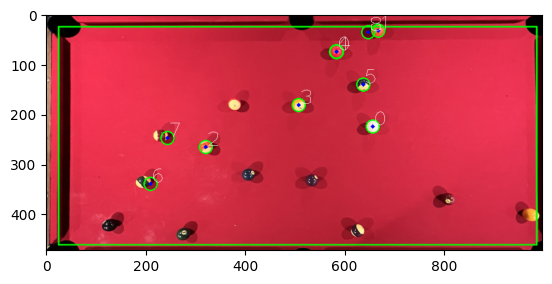

In [132]:
circles = hough_circles(final_out, '')
cimg = final_out
k = 0
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
    k+=1
plt.imshow(cimg)